## Architecture1: LLM 호출

In [2]:
from typing import Annotated, TypedDict 

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END, add_messages
from langgraph.checkpoint.memory import MemorySaver

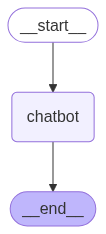

In [3]:
# 상태 공간 정의 

class State(TypedDict):
    """
    messages 유형은 list
    """
    messages: Annotated[list, add_messages] # 매 업데이트마다 기존의 내용을 갱신하지 않고 뒤에 붙임
    
builder = StateGraph(State)

model = ChatOpenAI(
    model = 'gpt-4o-mini', temperature=0.7,
)

def chatbot(state: State):
    answer = model.invoke(state['messages']) # 상태의 messages를 받아서 model이 응답 생성
    return {'messages': [answer]} 

# 챗봇 노드 추가 
# 첫 번째 인자는 노드 고유 이름, 두 번째 인자는 함수 또는 러너블
builder.add_node('chatbot', chatbot)

builder.add_edge(START, 'chatbot')
builder.add_edge('chatbot', END)

graph = builder.compile()
graph

In [3]:
input = {'messages': [HumanMessage("안녕하세요!")]}
for chunk in graph.stream(input):
    print(chunk)

{'chatbot': {'messages': [AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-ByTbz3OKDAbQ2I3JqDApfH3zqscwy', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--dd0d76a4-7d71-4094-8204-eb1b29691076-0', usage_metadata={'input_tokens': 10, 'output_tokens': 10, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}


## Architecture2: Chain & Flow Engineering

In [17]:
from typing import Annotated, TypedDict 
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages 

# SQL 쿼리 생성 LLM 
model_low_temp = ChatOpenAI(
    model = 'gpt-4o-mini', temperature=0.1
)

# 결과 출력 LLM
model_high_temp = ChatOpenAI(
    model = 'gpt-4o-mini', temperature=0.7
)

# 대화 기록 
class State(TypedDict):
    messages: Annotated[list, add_messages]
    
    user_query: str 
    # 출력 
    sql_query: str
    sql_explaination: str 
    
class Input(TypedDict):
    user_query: str 
    
class Output(TypedDict):
    sql_query: str 
    sql_explaination: str
    
    
generate_prompt = SystemMessage(
    """당신은 친절한 데이터 분석가입니다. 사용자의 질문을 바탕으로 SQL 쿼리를 작성하세요
    단계별로 생각해서 답변하세요
    확실하지 않거나 모르는 경우엔 모른다고 답변하세요
    """
)

def generate_sql(state: State) -> State:
    user_message = HumanMessage(state['messages'])
    messages = [generate_prompt, *state['messages'], user_message] # ?
    res = model_low_temp.invoke(messages)
    return {
        'sql_query' : res.content,
        'messages' : [user_message, res] # 대화 기록 업데이트 
    }
    
explain_prompt = SystemMessage(
    "당신은 친절한 데이터 분석가입니다. 사용자에게 SQL 쿼리를 누구나 쉽게 이해할 수 있게 설명하세요"
)

def explain_sql(state: State) -> State:
    messages = [
        explain_prompt, *state['messages']
    ]
    
    res = model_high_temp.invoke(messages)
    
    return {
        'sql_explaination': res.content,
        'messages': res,
    }

C:\Users\user\AppData\Local\Temp\ipykernel_7964\2947262939.py:1: LangGraphDeprecatedSinceV05: `input` is deprecated and will be removed. Please use `input_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(State, input = Input, output = Output)
C:\Users\user\AppData\Local\Temp\ipykernel_7964\2947262939.py:1: LangGraphDeprecatedSinceV05: `output` is deprecated and will be removed. Please use `output_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(State, input = Input, output = Output)


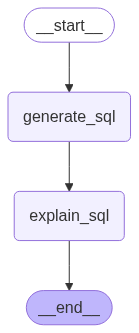

In [18]:
builder = StateGraph(State, input = Input, output = Output)
builder.add_node('generate_sql', generate_sql)
builder.add_node('explain_sql', explain_sql)
builder.add_edge(START, 'generate_sql')
builder.add_edge('generate_sql', 'explain_sql')
builder.add_edge('explain_sql', END)

graph = builder.compile()
graph

In [19]:
graph.invoke({'user_query': '각 품목의 판매량을 구해주세요'})

{'sql_query': '질문이 없으신 것 같습니다. 어떤 SQL 쿼리를 작성하는 데 도움이 필요하신지 말씀해 주시면, 단계별로 도와드리겠습니다!',
 'sql_explaination': "SQL 쿼리를 이해하기 쉽게 설명해 드리겠습니다. SQL(Structured Query Language)은 데이터베이스에서 데이터를 조회하거나 조작하는 데 사용되는 언어입니다. 제가 설명할 쿼리를 예를 들어 보겠습니다.\n\n예를 들어, 여러분이 'employees'라는 테이블에서 모든 직원의 이름과 급여를 조회하고 싶다고 가정해봅시다. 이때 사용할 수 있는 SQL 쿼리는 다음과 같습니다:\n\n```sql\nSELECT name, salary\nFROM employees;\n```\n\n이 쿼리를 단계별로 설명해 볼게요:\n\n1. **SELECT**: 이 키워드는 데이터베이스에서 어떤 데이터를 선택할 것인지를 지정합니다. 여기서는 `name`과 `salary`라는 두 개의 열(컬럼)을 선택했습니다. 즉, 직원의 이름과 급여를 보고 싶다는 뜻입니다.\n\n2. **FROM**: 이 키워드는 어떤 테이블에서 데이터를 가져올지를 지정합니다. 여기서는 `employees` 테이블에서 데이터를 가져오겠다고 명시했습니다.\n\n따라서 이 쿼리는 'employees' 테이블에서 모든 직원의 이름과 급여를 조회하여 보여주는 역할을 합니다.\n\n이제 다른 쿼리나 더 복잡한 예제가 필요하시면 말씀해 주세요!"}

## Architecture3: Router

Chain은 개발자가 정한 정적인 단계를 실행하는 반면, 라우터 아키텍처는 LLM이 미리 정의된 몇몇 단계 중 하나를 선택한다. 

### Multi-RAG Router

In [ ]:
from typing import Annotated, TypedDict, Literal

from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.vectorstores.in_memory import InMemoryVectorStore # 메모리에 저장하는 벡터 DB 
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.graph import START, END, StateGraph
from langgraph.graph import add_messages 

embeddings = OpenAIEmbeddings()

model_low_temp = ChatOpenAI(
    model = 'gpt-4o-mini', temperature=0.1,
)

model_high_temp = ChatOpenAI(
    model = 'gpt-4o-mini', temperature=0.7,
)

# 각 그래프 단계에서 입출력과 내부 상태 
class State(TypedDict):
    messages: Annotated[list, add_messages]
    user_query: str
    # 출력 
    domain: Literal['records', 'insurance']
    documents: list[Document] # 관련 문서 리스트 
    answer: str 

# 입/출력 스키마 명확화 
class Input(TypedDict):
    user_query: str 
    
class Output(TypedDict):
    documents: list[Document]
    answer: str

### 간단한 데이터셋 생성

In [13]:
from langchain_core.documents import Document

medical_documents = [
    Document(page_content="환자 001: 기침과 미열을 호소함. 흉부 X-ray에서 폐렴 소견 확인. 아지스로마이신 3일 처방."),
    Document(page_content="환자 002: 무거운 물건을 든 후 요통 발생. MRI에서 요추 디스크 탈출 확인. 물리치료 및 진통제 처방."),
    Document(page_content="환자 003: 정기 건강검진. 혈압 145/92로 고혈압 1단계 진단. 식이 및 운동요법 교육."),
    Document(page_content="환자 004: 우하복부 통증. CT에서 충수염 확인. 복강경 수술 의뢰."),
    Document(page_content="환자 005: 공복 혈당 168로 제2형 당뇨병 진단. 메트포르민 500mg 하루 2회 처방."),
    Document(page_content="환자 006: 인후통 및 발열. 신속검사에서 연쇄상구균 양성. 아목시실린 처방."),
    Document(page_content="환자 007: 운동 시 가슴 답답함 호소. 심전도 이상으로 운동 부하 검사 예약."),
    Document(page_content="환자 008: 재채기와 코막힘 지속. 알레르기 비염 진단. 로라타딘 처방."),
    Document(page_content="환자 009: 발목 염좌. X-ray 이상 없음. 냉찜질 및 휴식 권장."),
    Document(page_content="환자 010: 불안 및 불면 호소. GAD-7 점수 14. 에스시탈로프람 10mg 시작."),
    
    Document(page_content="환자 011: 흐릿한 시야와 두통. 혈압 180/100으로 고혈압 위기 대응."),
    Document(page_content="환자 012: 배뇨 시 작열감. 소변 검사에서 E. coli 검출. 요로감염 진단 및 항생제 처방."),
    Document(page_content="환자 013: 천식 진단. 폐활량 검사상 FEV1 저하. 흡입 스테로이드 시작."),
    Document(page_content="환자 014: 체질량지수 32. 비만 진단 후 영양사 상담 연계."),
    Document(page_content="환자 015: 편두통 재발. MRI 이상 없음. 예방적 치료로 토피라메이트 시작."),
    Document(page_content="환자 016: 가려움 동반 피부 발진. 접촉성 피부염 진단. 스테로이드 연고 처방."),
    Document(page_content="환자 017: 피로와 창백. 혈색소 수치 9.5. 철분 결핍성 빈혈 진단."),
    Document(page_content="환자 018: 무릎 통증. X-ray상 경증 골관절염 소견. 물리치료 권장."),
    Document(page_content="환자 019: 자궁경부 세포검사 결과 LSIL. 정밀검사 위해 산부인과 의뢰."),
    Document(page_content="환자 020: 호흡곤란 호소. 산소포화도 91%. COPD 악화 의심, 네불라이저 치료."),
    
    Document(page_content="환자 021: 손 저림. 신경전도검사 결과 손목터널증후군 진단."),
    Document(page_content="환자 022: 당뇨병성 족부 궤양 2단계. 상처 관리 및 항생제 시작."),
    Document(page_content="환자 023: 고열 및 발진 동반. 홍역 진단."),
    Document(page_content="환자 024: 코로나19 완치 후 추적 검사. 합병증 없음."),
    Document(page_content="환자 025: 만성 위염. 내시경 소견상 위 점막 손상. 위산 억제제 4주 처방."),
    Document(page_content="환자 026: 흉통으로 내원. 트로포닌 상승. 비ST 상승 심근경색 진단."),
    Document(page_content="환자 027: 독감 백신 접종 완료. 이상 반응 없음."),
    Document(page_content="환자 028: 관절 부종 및 통증. 류마티스 관절염 진단. 류마티스내과 의뢰."),
    Document(page_content="환자 029: 중이염 진단. 아목시실린-클라불란산 복합제 처방."),
    Document(page_content="환자 030: 우울감 호소. PHQ-9 점수 9. 인지행동치료 권유."),
]


In [14]:
from langchain_core.documents import Document

insurance_documents = [
    Document(page_content="1. 건강보험 가입 시 필요한 서류는 무엇인가요?"),
    Document(page_content="2. 보험료는 어떤 방식으로 납부하나요?"),
    Document(page_content="3. 보험료 납부를 연체하면 어떤 불이익이 있나요?"),
    Document(page_content="4. 보장 범위는 어떤 항목을 포함하나요?"),
    Document(page_content="5. 치과 치료도 보장이 되나요?"),
    Document(page_content="6. 한방 치료도 보험 혜택을 받을 수 있나요?"),
    Document(page_content="7. 입원 시 보상은 어떻게 되나요?"),
    Document(page_content="8. 실손보험과 건강보험의 차이점은 무엇인가요?"),
    Document(page_content="9. 보험금 청구는 어떻게 하나요?"),
    Document(page_content="10. 보험금 청구 시 필요한 서류는 무엇인가요?"),

    Document(page_content="11. 가족 모두가 가입할 수 있는 보험이 있나요?"),
    Document(page_content="12. 자녀를 위한 보험 상품은 어떤 것이 있나요?"),
    Document(page_content="13. 암 진단을 받으면 얼마나 보장되나요?"),
    Document(page_content="14. 기존 질환이 있는 경우에도 가입할 수 있나요?"),
    Document(page_content="15. 보험 가입 후 바로 보장되나요? 대기기간은 어떻게 되나요?"),
    Document(page_content="16. 보험 계약 해지는 어떻게 하나요?"),
    Document(page_content="17. 중도 해지 시 환급금은 얼마인가요?"),
    Document(page_content="18. 보험 해지 후 다시 가입할 수 있나요?"),
    Document(page_content="19. 보험 상품을 변경하고 싶은데 가능한가요?"),
    Document(page_content="20. 보험 수혜자(수익자)는 언제든 변경 가능한가요?"),

    Document(page_content="21. 보험 가입 연령 제한이 있나요?"),
    Document(page_content="22. 보험사고 접수는 어디서 하나요?"),
    Document(page_content="23. 보험금은 언제 지급되나요?"),
    Document(page_content="24. 외국에서 치료받은 것도 보장되나요?"),
    Document(page_content="25. 코로나19로 인한 입원비도 보장되나요?"),
    Document(page_content="26. 재가입 시 보장 내용은 동일한가요?"),
    Document(page_content="27. 모바일로도 보험금 청구가 가능한가요?"),
    Document(page_content="28. 실비 보험과 의료비 보장은 어떤 차이가 있나요?"),
    Document(page_content="29. 진단서 없이 보험 청구가 가능한 경우가 있나요?"),
    Document(page_content="30. 보험 상담은 어디에서 받을 수 있나요?"),
]


### In-Memory vectorDB 설정 

In [26]:
medical_records_store = InMemoryVectorStore.from_documents(medical_documents, embeddings)
medical_records_retriever = medical_records_store.as_retriever() # db 기반 검색기 생성 
medical_records_retriever

VectorStoreRetriever(tags=['InMemoryVectorStore', 'OpenAIEmbeddings'], vectorstore=<langchain_core.vectorstores.in_memory.InMemoryVectorStore object at 0x000002DC9CBC9EA0>, search_kwargs={})

In [27]:
insurance_faqs_store = InMemoryVectorStore.from_documents(insurance_documents, embeddings)
insurance_faqs_retriever = insurance_faqs_store.as_retriever()
insurance_faqs_retriever

VectorStoreRetriever(tags=['InMemoryVectorStore', 'OpenAIEmbeddings'], vectorstore=<langchain_core.vectorstores.in_memory.InMemoryVectorStore object at 0x000002DCBD37AD10>, search_kwargs={})

In [28]:
router_prompt = SystemMessage(
    '''사용자 문의를 어느 도메인으로 라우터할지 결정하세요. 선택할 수 있는 두 가지 도메인은 다음과 같습니다
    - records: 진단, 치료, 처방과 같은 환자의 의료 기록을 포함합니다.
    - insurance: 보험 정책, 청구, 보장에 대한 자주 묻는 질문을 포함합니다.
    
    도메인 이름만 출력하세요'''
)
router_prompt

SystemMessage(content='사용자 문의를 어느 도메인으로 라우터할지 결정하세요. 선택할 수 있는 두 가지 도메인은 다음과 같습니다\n    - records: 진단, 치료, 처방과 같은 환자의 의료 기록을 포함합니다.\n    - insurance: 보험 정책, 청구, 보장에 대한 자주 묻는 질문을 포함합니다.\n    \n    도메인 이름만 출력하세요', additional_kwargs={}, response_metadata={})

### Router node 정의

In [44]:
def router_node(state: State) -> State:
    user_messages = HumanMessage(state['messages'])
    messages = [router_prompt, *state['messages'], user_messages]
    
    res = model_low_temp.invoke(messages)
    
    return {
        'domain': res.content,
        # 대화 기록 업데이트
        'messages': [user_messages, res]
    }

### domain 검색기 설정

In [ ]:
def pick_retriever(
    state: State,
) -> Literal['retrieve_medical_records', 'retrieve_insurance_faqs']:
    # 2개의 domain 중에 하나여야함 
    if state['domain'] == 'records':
        return "retrieve_medical_records"
    else:
        return "retrieve_insurance_faqs"

### domain별 관련 documents return 함수

In [39]:
def retrieve_medical_records(state: State) -> State:
    documents = medical_records_retriever.invoke(state['user_query'])
    return {
        "documents": documents,
    }

In [40]:
def retrieve_insurance_faqs(state: State) -> State:
    documents = insurance_faqs_retriever.invoke(state['user_query'])
    return {
        'documents': documents,
    }

In [ ]:
medical_records_prompt = SystemMessage(
    '당신은 유능한 의료 전문가입니다. 진단, 치료, 처방과 같은 환자의 의료 기록을 기반으로 질문에 답하시오'
)

insurance_faqs_prompt = SystemMessage(
    '당신은 유능한 의료 보험 전문가입니다. 보험 정책, 청구 및 보장에 대한 자주 뭍는 질문에 답하세요.'
)

# 답변 생성 함수 정의 
def generate_answer(state: State) -> State:
    if state['domain'] == 'records':
        prompt = medical_records_prompt
    elif state['domain'] == 'insurance':
        prompt = insurance_faqs_prompt
    else:
        raise ValueError(f"Unknown domain: {state['domain']}")
        
    # messages = [
    #     prompt,
    #     *state['messages'],
    #     HumanMessage(f"Documemts: {state['documents']}"), -> Python 객체 정보 전달 가능성 O
    #     HumanMessage(content = f"위 문서 내용을 참고하여 질문에 답변해주세요")
    # ]
    
     # 문서 리스트를 텍스트로 합치기
     # page_content만 추출하여 명확한 의미 전달 
    docs_text = "\n".join(doc.page_content for doc in state['documents'])

    messages = [
        prompt,
        *state['messages'],
        HumanMessage(content=f"다음은 관련 문서들입니다:\n{docs_text}"),
        HumanMessage(content=f"사용자 질문: {state['user_query']}"),
        HumanMessage(content="위 문서 내용을 참고해 질문에 답변해 주세요."),
    ]
    
    res = model_high_temp.invoke(messages)
    
    return {
        'answer': res.content,
        'messages': res,
    }

C:\Users\user\AppData\Local\Temp\ipykernel_16368\2076053154.py:1: LangGraphDeprecatedSinceV05: `input` is deprecated and will be removed. Please use `input_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(State, input = Input, output = Output)
C:\Users\user\AppData\Local\Temp\ipykernel_16368\2076053154.py:1: LangGraphDeprecatedSinceV05: `output` is deprecated and will be removed. Please use `output_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  builder = StateGraph(State, input = Input, output = Output)


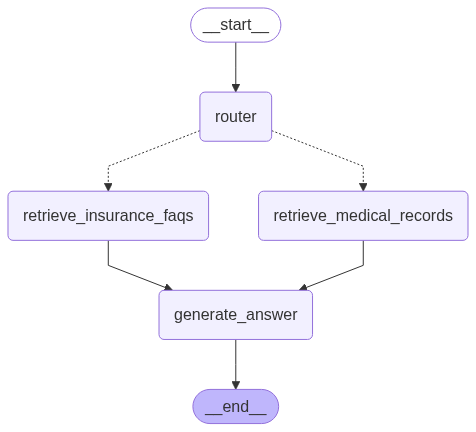

In [52]:
builder = StateGraph(State, input = Input, output = Output)

builder.add_node('router', router_node)
builder.add_node('retrieve_medical_records', retrieve_medical_records)
builder.add_node('retrieve_insurance_faqs', retrieve_insurance_faqs)
builder.add_node('generate_answer', generate_answer)
builder.add_edge(START, 'router')
builder.add_conditional_edges('router', pick_retriever)
builder.add_edge('retrieve_medical_records', 'generate_answer')
builder.add_edge('retrieve_insurance_faqs', 'generate_answer')
builder.add_edge('generate_answer', END)

graph = builder.compile()
graph

In [53]:
input = {'user_query': '지금 피부가 전체적으로 간지러운데 왜 그런건가요?'}
for c in graph.stream(input):
    print(c)

{'router': {'domain': 'records', 'messages': [HumanMessage(content=[], additional_kwargs={}, response_metadata={}, id='ae2f6a7b-c0e2-46af-a397-fb0a49b8f118'), AIMessage(content='records', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1, 'prompt_tokens': 95, 'total_tokens': 96, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef', 'id': 'chatcmpl-ByY1Jbdrbs0ep02B4EelYW5xjnIlj', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--a7f841c1-3055-450a-9ed2-9b530100f4ee-0', usage_metadata={'input_tokens': 95, 'output_tokens': 1, 'total_tokens': 96, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}
{'retrieve_medical_records': {'do